<h2>Threshold model</h2>
<p>
In a photo sharing social network (Instagram), people post pictures of the icecreams they are eating. When users upload a photo, all their friends are notified. Friendhsip links are directioned according to the information flow: a directed edge A->B means that B follows A and that B is notified with A's profile updates.
</p>
<p>
We observe a series of "icecream consumptions" (in the form <i>[userA, timeX]</i>) over a period of time. Some users might consume icecream multiple times. The social network is static over that period of time. We would like to check whether the icecream consumption is driven by a phenomenon of "social contagion".
</p>
<p>
<b>Hypothesis: People consume an icecream when more than x% of their friends have recently consumed an icecream <i>(activation threshold)</i>.</b>
</p>
<hr>

<font size="4"><b>STEP 0: Setup</b></font>
<p>Imports and utility methods. We set our notion of "recent" to 6 hours (as excercise, you can play with this constant)</p>

In [1]:
#Imports and variables
import sys
import math
import bisect
import heapq
from random import shuffle

import numpy as np
import scipy.stats
import igraph
import matplotlib.pyplot as plt

%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

INFLUENCE_MAX_DELAY=21600 #6 hours

%matplotlib inline
print('Ready to go!')

Ready to go!


In [2]:
#Utility methods
def read_dictionary(filename, separator='\t',castKeyToNumber=False,castValueToNumber=False,keyIndex=0,valueIndex=None):
    """
    file: KEY VALUE [VALUE ... VALUE]
    """
    f_in = open(filename,'r')
    dictionary={}
    if valueIndex != None:
        for line in f_in.readlines():
            line=line.rstrip('\n').rstrip(' ').rstrip('\r')
            elements = line.split(separator)
            k=elements[keyIndex]
            v=elements[valueIndex]
            if castKeyToNumber:
                k=float(k)
            if castValueToNumber:
                v=float(v)
            dictionary[k]=v
    else:
        for line in f_in.readlines():
            line=line.rstrip('\n').rstrip(' ').rstrip('\r')
            elements = line.split(separator)
            k=elements[keyIndex]
            v=elements[keyIndex+1:len(elements)]
            if castKeyToNumber:
                k=float(k)
            if castValueToNumber:
                v=map(float,v)
            dictionary[k]=v
    return dictionary

def write_dictionary(dictionary, filename, separator='\t'):
    outFile = open(filename,"w")
    for x in sorted(dictionary.keys()) :
        outFile.write(str(x)+separator+str(dictionary[x])+'\n')
    outFile.close()

def histogram(vals,normalized=False):
    d={}
    for v in vals:
        d.setdefault(v,0)
        d[v]+=1
    if normalized:
        tot=float(sum(d.values()))
        for k in d.keys():
            d[k]=d[k]/tot
    return d

def randomize_dict(d):
    keys = [x for x in d.keys()]
    vals = [y for y in d.values()]
    shuffle(vals)
    return dict(zip(keys, vals))

def load_graph(graph_file, directed=False, weighted=False, graph_file_type='ncol'):
    if graph_file_type.lower() == 'pajek':
        g = igraph.Graph.Read_Pajek(graph_file)
    elif graph_file_type.lower() == 'edgelist':
        g = igraph.Graph.Read_Edgelist(graph_file, directed)
    elif graph_file_type.lower() == 'ncol':
        g = igraph.Graph.Read_Ncol(graph_file, names=False, weights=weighted, directed=directed)
    else:
        raise Exception('Invalid file type')
    return g

def to_sequence(d):
    """
    d: nodeid -> ts
    return: nodeid -> sequenceNo
    """
    seq = []
    res = {}
    seq = sorted([(d[k],k) for k in d.keys()])
    i=0
    for x in seq :
        res[x[1]]=i
        i+=1
    return res

<font size="4"><b>STEP 1: Graph analysis</b></font>
<p>We check whether basic conditions for a contagion model could hold in the graph at hand (e.g., is the graph actually connected?). To do that, we load the graph (with <i>igraph</i>) and check its basic structural properties.</p>

#Nodes = 70003
#Edges = 1096489
Density = 0.00022375728236910755
Reciprocity = 0.3154742090435928
Clustering coefficient (undir) = 0.12428871394859643
------------
#Strongly Connected Components (SCC) = 11574
#Nodes Giant SCC = 57751
#Edges Giant SCC = 1050651
#Density Giant SCC = 0.0003150264222107134
Reciprocity Giant SCC = 0.32793001672296507
Clustering coefficient (undir) = 0.1244333570349845
------------
#Weakly Connected Components (WCC) = 122
#Nodes Giant WCC = 69758
#Edges Giant WCC = 1096272
#Density Giant WCC = 0.00022528719428720477
Reciprocity Giant WCC = 0.3153669892143556
Clustering coefficient (undir) = 0.12429460627068628


Text(0,0.5,'Count')

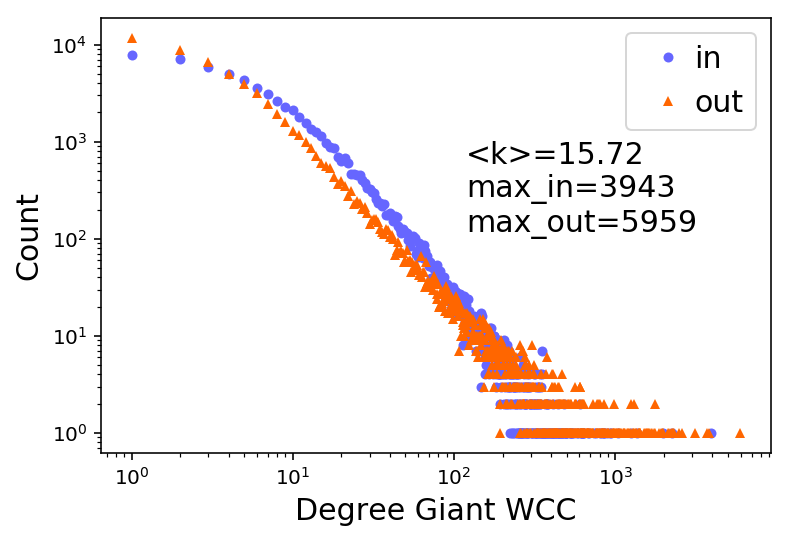

In [3]:
g = load_graph('graph', directed=True, weighted=False, graph_file_type='ncol')

#NODES AND EDGES
print('#Nodes = %s'%len(g.vs))
print('#Edges = %s'%len(g.es))
print('Density = %s'%g.density())
print('Reciprocity = %s'%g.reciprocity(ignore_loops=True, mode="default"))
print('Clustering coefficient (undir) = %s'%g.transitivity_avglocal_undirected(mode='nan', weights=None))

#COMPONENTS
sccs = g.components(mode="STRONG")
s_gcc = sccs.giant()
print('------------')
print('#Strongly Connected Components (SCC) = %s'%len(sccs))
print('#Nodes Giant SCC = %s'%len(s_gcc.vs))
print('#Edges Giant SCC = %s'%len(s_gcc.es))
print('#Density Giant SCC = %s'%s_gcc.density())
print('Reciprocity Giant SCC = %s'%s_gcc.reciprocity(ignore_loops=True, mode='default'))
print('Clustering coefficient (undir) = %s'%s_gcc.transitivity_avglocal_undirected(mode='nan', weights=None))

wccs = g.components(mode="WEAK")
w_gcc = wccs.giant()
print('------------')
print('#Weakly Connected Components (WCC) = %s'%len(wccs))
print('#Nodes Giant WCC = %s'%len(w_gcc.vs))
print('#Edges Giant WCC = %s'%len(w_gcc.es))
print('#Density Giant WCC = %s'%w_gcc.density())
print('Reciprocity Giant WCC = %s'%w_gcc.reciprocity(ignore_loops=True, mode='default'))
print('Clustering coefficient (undir) = %s'%w_gcc.transitivity_avglocal_undirected(mode='nan', weights=None))

#DEGREE DISTRIBUTION
deg = w_gcc.degree()
in_deg = w_gcc.indegree()
out_deg = w_gcc.outdegree()

in_deg_hist = histogram(in_deg,normalized=False)
plt.plot([x for x in in_deg_hist.keys()], [y for y in in_deg_hist.values()], 'o', color='#6666FF', markersize=5, markeredgewidth=0)
out_deg_hist = histogram(out_deg,normalized=False)
plt.plot([ x for x in out_deg_hist.keys()], [y for y in out_deg_hist.values()], '^', color='#FF6600', markersize=5, markeredgewidth=0)
plt.text(max(out_deg_hist.keys())/50, max(out_deg_hist.values())/100, fontsize=15, s='<k>=%s\nmax_in=%s\nmax_out=%s'%(round(np.mean(in_deg),2),max(in_deg_hist.keys()),max(out_deg_hist.keys())))

plt.legend(['in','out'], loc='upper right',frameon=True,numpoints=1,fontsize=15,markerscale=1,handletextpad=-0.1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree Giant WCC', fontsize=15)
plt.ylabel('Count', fontsize=15)
    

<font size="4"><b>STEP 2: Activation threshold analysis</b></font>
<p>By looking at the actual sequence of activations (icecream consumptions) we can measure empirically the activation threshold for every activation: in the instant a node consumes an icecream, what is the percentage of its neighbors who had recently consumed an icecream?</p>
<p>The same measurement can be done on a randomized baseline where the activation sequences are randomly reshuffled between different nodes. The difference between the randomized model and the real data gives a first indication that the activations observed might be generated by a contagion process and not by structural artifacts of the network itself.</p>

In [4]:
def compute_thresholds(g,nodeid2activations, randomized=False):
    """
    g: a graph
    nodeid2activations: nodeid->[ts1,...,tsN]
    randomized: true to randomize the key-value associations of the nodeid2activations dict
    
    Returns: thresholds: list of thresholds
             activation_seeds: [(ts,nodeid)]
    """
    if randomized:
        nodeid2activations = randomize_dict(nodeid2activations)
    
    #initialize the activation times of all nodes
    for node in g.vs:
        node['ts']=None
        
    for nid in nodeid2activations:
        g.vs[nid]['ts']=nodeid2activations[nid]

    thresholds=[]
    activation_seeds=[]
    for n in g.vs: #loops over all nodes
        n_activations=n['ts']
        if n_activations != None: #if the node had some activation time
            kn = g.degree(n,mode=igraph.IN)
            neighborhood = g.neighbors(n,mode=igraph.IN)
            for activation_time in n_activations: #loops over all the activation times of that node
                active_neighbors = 0.0
                for m in neighborhood: #for all its IN-neighbors
                    m_activations=g.vs[m]['ts']
                    if m_activations != None:
                        i = bisect.bisect(m_activations,activation_time) #take the neighbor most recent activation time
                        if i>0:
                            previous_activation_time_neighbor = m_activations[i-1]
                            #if that happened recently in the past
                            if (activation_time-previous_activation_time_neighbor <= INFLUENCE_MAX_DELAY):
                                #then the node had an active neighbor at its activation time
                                active_neighbors+=1.0
                #compute the ratio of active neighbors at acivation time
                if kn>0:
                    n_threshold = active_neighbors/kn
                else:
                    n_threshold = 0
                #if the ratio is zero, it means that the node was active but not because of contagion (seed)
                if n_threshold==0:
                    activation_seeds.append((activation_time,n.index))
                thresholds.append(round(n_threshold,2))

    #clean up graph
    for node in g.vs:
        node['ts']=None
    
    return thresholds, activation_seeds
        

In [5]:
#compute empirical activation thresholds on the data (plus a random baseline)
nodeid2activations={}
for line in open('nodeid2activation_normal'):
    tokens=line.replace('\n','').split('\t')
    nodeid2activations[int(tokens[0])]=[int(x) for x in tokens[1].split(',')]

thresholds_real, activation_seeds = compute_thresholds(g, nodeid2activations, randomized=False)
thresholds_rand, activation_seeds_rand = compute_thresholds(g, nodeid2activations, randomized=True)

(0, 0.05)

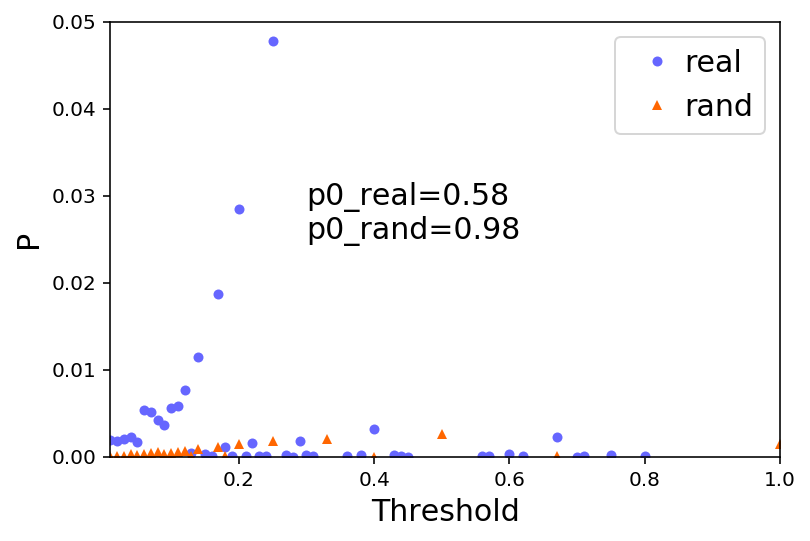

In [6]:
#plot the distribution of thresholds
thresholds_real_hist = histogram(thresholds_real,normalized=True)
p0_real = round(thresholds_real_hist[0],2)
plt.plot([x for x in thresholds_real_hist.keys()], [ y for y in thresholds_real_hist.values()], 'o', color='#6666FF', markersize=5, markeredgewidth=0)
mean_real = np.mean(thresholds_real)

thresholds_rand_hist = histogram(thresholds_rand,normalized=True)
p0_rand = round(thresholds_rand_hist[0],2)
plt.plot([x for x in thresholds_rand_hist.keys()], [y for y in thresholds_rand_hist.values()], '^', color='#FF6600', markersize=5, markeredgewidth=0)
mean_rand = np.mean(thresholds_rand) 

plt.text(0.3,0.025, fontsize=15, s='p0_real=%s\np0_rand=%s'%(p0_real,p0_rand))
plt.legend(['real','rand'], loc='upper right',frameon=True,numpoints=1,fontsize=15,markerscale=1,handletextpad=-0.1)
plt.xlabel('Threshold', fontsize=15)
plt.ylabel('P', fontsize=15)
plt.xlim((0.01,1))
plt.ylim((0,0.05))


<font size="4"><b>STEP 3: Threshold model</b></font>
<p>The distribution of activation thresholds is very different from the random case. The majority of nodes become active when none of their neighbors is active. We call <b>seed nodes</b> those nodes that activate spontaneously, with no influence from others.</p>
<p>So we ask if the activations of the remaining nodes (the ones that are not seeds) are driven by peer influence. In the empirical distribution, we observe different thresholds, the most frequent being in between 0.2 and 0.3. To verify if the threshold model can explain these activations, we should run the model starting from the seed nodes. The model can be implemented with a simple algorithm:
<ol>
<li>Sort the sequence of activations for the seed nodes and scan it in temporal order</li>
<li>When a node <i>X</i> gets active at time <i>t</i>, parse its neighbors. For each neighbor <i>Y</i>:</li>
    <ol>
    <li>Check the portion of <i>Y</i>'s neighbors that are active</li>
    <li>If the portion is greater than a threshold, insert a new activation <i>(Y,t+delta)</i> in the ordered activation list</li>
    </ol>
<li> Terminate when the activation sequence is empty </li>
</ol>


In [7]:
def threshold_model(g,activation_seeds,contagion_threshold,verbose=False):
    """
    g: a graph
    activation_seeds: (ts, nodeid)
    influenced_count: node -> #times influenced
    contagion_threshold: either a dict node->threshold or a float (same treshold for everyone)
    
    Returns: contagions: node->[ts1,...,tsN]
    """
    contagions={} #output dictionary node->[times_of_contagion]
    seed_nodes = set([x[1] for x in activation_seeds])
    
    thresholds={} #nodeid -> contagion threshold
    if type(contagion_threshold)==dict:
        thresholds=contagion_threshold
    elif type(contagion_threshold)==int or type(contagion_threshold)==float:
        if contagion_threshold >=0 and contagion_threshold <= 1:
            for node in g.vs:
                n = node.index
                thresholds[n] = contagion_threshold
        else:
            raise exception('Threshold must be dict of within [0,1]')
    else:
        raise exception('Threshold must be dict of within [0,1]')
    
    #the initializes all the contagion times of nodes in the graph to None
    for node in g.vs:
        node['ts']=None
    
    #heap of (ts, nodeid), where nodeids are the seeds
    activations = []
    for a in activation_seeds:
        heapq.heappush(activations, a)
    #print len(activations)

    cnt=0
    infection_count=0 #counts the number of times nodes are infected 
    while(len(activations) > 0): #while there's still some event in the heap
        a = heapq.heappop(activations) #take the most recent event
        #print a
        t = a[0]
        nid = a[1]
        node = g.vs[nid]
        node['ts'] = t #assign the activation time to the corresponding node
        
        #all the OUT-neighbors of that node are potentially influenced by that node's activation
        influenced_nodes = g.neighbors(node,mode=igraph.OUT)
        #print influenced_nodes
        for potential_node in influenced_nodes: #loop over all the potentially affected nodes
            if True:#node not in seed_nodes: #ignore seed nodes
                prev_activation = g.vs[potential_node]['ts'] #retrieve any previous activation time of that node
                #consider the node only if the node has not been active ever or the last time it was active was a long ago
                if prev_activation == None or t-prev_activation >= INFLUENCE_MAX_DELAY:
                    kn = g.degree(potential_node,mode=igraph.IN) #compute its indegree
                    neighborhood = g.neighbors(potential_node,mode=igraph.IN) #and the set of in-neighbors
                    #print 'P', potential_node, neighborhood
                    active_neighbors = 0.0
                    for m in neighborhood: #for all its in-neighbors
                        m_last_activation=g.vs[m]['ts'] #take their activation time
                        if m_last_activation != None: #if they had been active...
                            if (t-m_last_activation <= INFLUENCE_MAX_DELAY): #...in the recent past
                                active_neighbors+=1.0 #then the current node has an active neighbor more
                    n_threshold = active_neighbors/kn #overall, this is the ratio of active neighbors

                    if n_threshold >= thresholds[potential_node]: #if the ratio of active neighbors is above the threshold
                        #print '>',potential_node
                        infection_count+=1 #the node will get infected...
                        #newtime = t + (np.random.exponential(1) * 100) #...shortly later in time
                        newtime = t + 1 #...shortly later in time
                        contagions.setdefault(potential_node,[])
                        contagions[potential_node].append(newtime)
                        g.vs[potential_node]['ts']=newtime
                        heapq.heappush(activations,(newtime,potential_node)) #a new infection event is put in the heap
        
        cnt+=1
        if verbose:
            if cnt%10000==0:
                print('%s,%s,%s'%(cnt, len(activations), infection_count))
    
    return contagions

<font size="4"><b>STEP 3.1: Threshold model - Toy example</b></font>
<p>Let's try the threshold model on a toy graph first. Below, a visual representation of the graph at the beginning of the simulation (time 100) and at the end of it. Red nodes are the ones that are active at some point in time. In this example, we pick 0.5 as threshold (half of my neighbors need to be active for me to activate) but different threshold could lead to the same outcome.</p>
<p>You can play with the example by changing the seed (example_activation_seed variable) or the threshold (example_threshold)</p>

<img src="example.png">

In [8]:
example_g = load_graph('example_graph', directed=True, weighted=False, graph_file_type='ncol')
example_activation_seed = [(100,0)]
example_threshold=0.5
print('Graph:')
print (example_g)
print('\nSeed: Node 0 at time 100')
example_activations = threshold_model(example_g,example_activation_seed,example_threshold)
write_dictionary(example_activations,'node2activation_example')
print('\nActivation sequence (time, node):')
for t,n in sorted([(example_activations[k], k) for k in example_activations.keys()]):
    print('%s,%s'%(t,n))

Graph:
IGRAPH D--- 10 15 --
+ edges:
0->1 0->2 1->3 1->4 1->5 2->4 3->5 3->6 4->7 5->6 7->5 6->3 8->3 8->6 9->5

Seed: Node 0 at time 100

Activation sequence (time, node):
[101],1
[101],2
[102],4
[103],7
[104],5


<font size="4"><b>STEP 3.1: Threshold model - Simulation</b></font>
</p>Now, we shift to our real dataset, and we run the model for several different thresholds, including those in the [0.2,0.3] interval that seemed to be the most promising.<p>

In [9]:
models = {}
for contagion_threshold in [0.20,0.30,0.40,0.50,0.60]:
    print('Running simulation for threshold %s...'%contagion_threshold)
    models[contagion_threshold] = threshold_model(g,activation_seeds,contagion_threshold)
print('Done!')

Running simulation for threshold 0.2...
Running simulation for threshold 0.3...
Running simulation for threshold 0.4...
Running simulation for threshold 0.5...
Running simulation for threshold 0.6...
Done!


In [10]:
shuffled_models={}
for k in models.keys():
    shuffled_models[k]=randomize_dict(models[k])

<font size="4"><b>STEP 4: Evaluation</b></font>
</p>We need to assess to which extent the threshold model works and, if so, which threshold describes the observed facts best. To do that, we need to establish some evaluation metrics to establish in a quantitative way how well the model describes the reality. We'd like to measure three things:</p>

<p><b>Precision/recall.</b> How much the set of active nodes in the real data differs from the set of nodes that are predicted to be active by the model. Of course, there is a precision/recall tradeoff. To account for that we use the F1 metric: $$F1 = \frac{2 \cdot TP}{2\cdot TP + FP + FN}$$</p>

<p><b>Number of activations.</b></p> A node can be active multiple times. We would like our model to predict the right number of times, at least in relative terms. If node <i>X</i> gets activated more times than node <i>Y</i>, we would like that also our model to predict that the number of activations for <i>X</i> is higher than for <i>Y</i>. We compute the rank correlation (Spearman) between the vector of number of activations in the real data and in the model.</p>

<p><b>Temporal order of activations.</b>We would like the model to predict the exact sequence of activations. To make things easier, we take into account only the first time a node is activated and compute the rank correlation (Spearman) between the activation times in the real data and in the model.</p> 


In [11]:
def compare_traces(activations_real, activations_model):
    """
    activations: node->[ts1,...,tsN]
    returns: (F1_measure, Spearman_number_of_activations, Spearman_order_of_activations)
    """
    predicted_nodes = set([x for x in activations_model.keys()])
    real_nodes = set([x for x in activations_real.keys()])
    common_nodes = predicted_nodes.intersection(real_nodes)
    P = float(len(real_nodes))
    TP = float(len(common_nodes))
    FP = float(len(predicted_nodes.difference(real_nodes)))
    FN = float(len(real_nodes.difference(predicted_nodes)))
    F1 = 2*TP / (2*TP + FP + FN)
    
    count_predicted=[]
    count_real=[]
    for n in common_nodes:
        count_predicted.append(len(activations_model[n]))
        count_real.append(len(activations_real[n]))
    Rcount = scipy.stats.spearmanr(count_predicted,count_real)

    predicted_nodes_ordered = to_sequence({k: activations_model[k] for k in common_nodes})
    predicted_nodes_sequence = [predicted_nodes_ordered[nid] for nid in sorted(predicted_nodes_ordered.keys())]
    
    real_nodes_ordered = to_sequence({k: activations_real[k] for k in common_nodes})
    real_nodes_sequence = [real_nodes_ordered[nid] for nid in sorted(predicted_nodes_ordered.keys())]

    R_order = scipy.stats.spearmanr(real_nodes_sequence,predicted_nodes_sequence)
    Rrand = scipy.stats.spearmanr(real_nodes_sequence,np.random.random(len(real_nodes_sequence)))
    
    return (F1,Rcount,R_order)
    

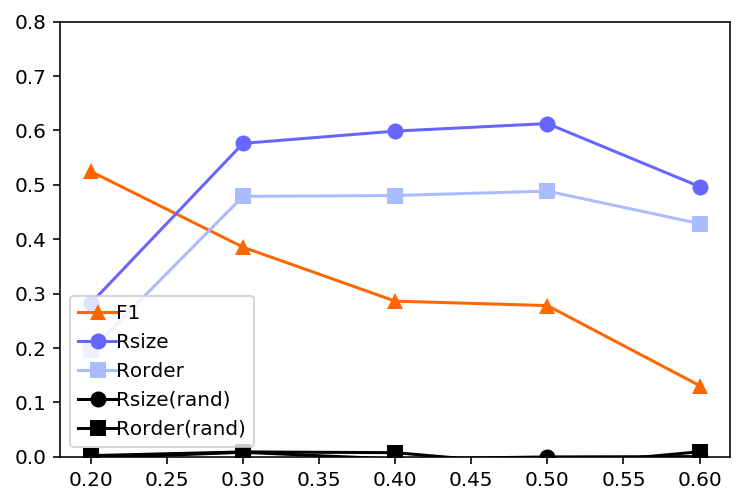

In [12]:
x=[i for i in sorted(models.keys())]
y_F1=[]
y_size=[]
y_order=[]
y_size_rand=[]
y_order_rand=[]
for contagion_threshold in x:
    F1,R_size,R_order = compare_traces(models[contagion_threshold],nodeid2activations)
    F1_rand,R_size_rand,R_order_rand = compare_traces(shuffled_models[contagion_threshold],nodeid2activations)
    y_F1.append(F1)
    y_size.append(R_size[0])
    y_size_rand.append(R_size_rand[0])
    if (R_size[1] > 0.01): #check p-value
        print('warning! p-value for treshold=%s in size correlation is %s'%(contagion_threshold,R_size[1]))
    y_order.append(R_order[0])
    y_order_rand.append(R_order_rand[0])
    if (R_order[1] > 0.01): #check p-value
        print('warning! p-value for treshold=%s in order correlation is %s'%(contagion_threshold,R_order[1]))

plt.plot(x, y_F1, '^-', color='#FF6600', markersize=8, markeredgewidth=0)
plt.plot(x, y_size, 'o-', color='#6666FF', markersize=8, markeredgewidth=0)
plt.plot(x, y_order, 's-', color='#AABBFF', markersize=8, markeredgewidth=0)
plt.plot(x, y_size_rand, 'o-', color='#000000', markersize=8, markeredgewidth=0)
plt.plot(x, y_order_rand, 's-', color='#000000', markersize=8, markeredgewidth=0)
plt.ylim((0,0.8))
plt.legend(['F1','Rsize','Rorder','Rsize(rand)','Rorder(rand)'], loc='lower left',frameon=True,numpoints=1,fontsize=10,markerscale=1,handletextpad=-0.1)

<font size="4"><b>STEP 5: Result interpretation</b></font>
<p>The correlation with the number and order of activation plateaus between 0.3 and 0.55. Among those values, 0.3 has the highest F1 score. Therefore, we conclude that the best model that describes the phenomenon, among the ones we have tried, is the one with threshold 0.3.</p>
<p>How good are these results? Compared to a random expectation (lines in black) the results are very good, plus, rank correlations in the ballpark of [0.5,0.6] are pretty high per se. On the basis of what you observed, can you think of any other hypothesis you could test to reinforce (or refine) the theory about contagion for icecream consumption?</p>